In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from zoneinfo import ZoneInfo

# Data Collection

Text(0, 0.5, 'Temperature [°C]')

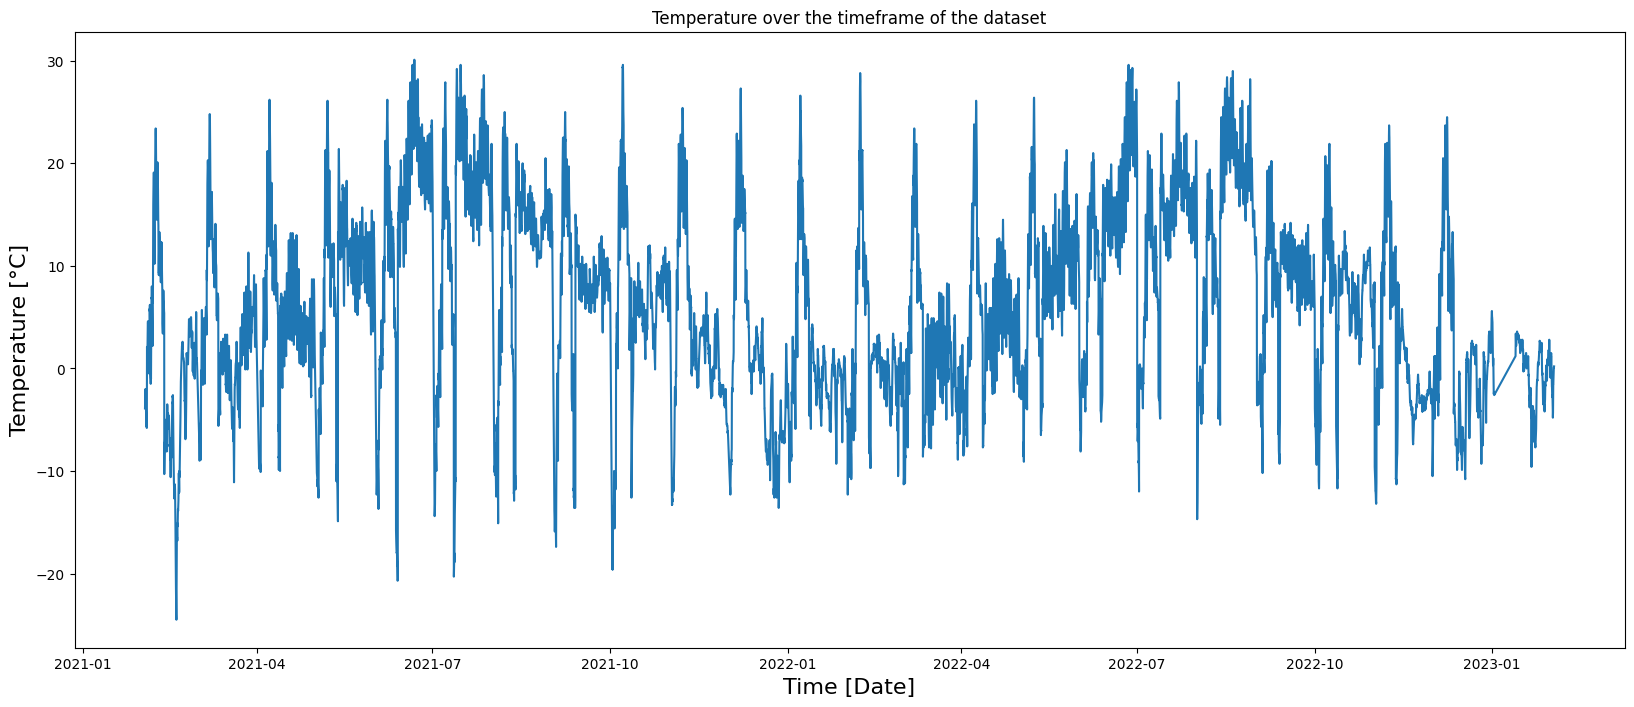

In [37]:
# import dataset and transform timestamp
df = pd.read_csv('data/solar_243171.csv', delimiter=',', decimal='.')
df['ts'] = df['timestamp']
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).map(lambda x: x.tz_convert('Europe/Tallinn'))

if pd.Series(df["timestamp"]).is_unique:
    df.set_index('timestamp', inplace=True)

# show temperature first
plt.figure(figsize=(20,8))
plt.title("Temperature over the timeframe of the dataset")
p = sns.lineplot(data=df['temperature'])
p.set_xlabel("Time [Date]", fontsize=16)
p.set_ylabel("Temperature [°C]", fontsize=16)

In [38]:
# check timestamp steps (search if ts are missing)
df['time_delta'] = df.index.diff().total_seconds()
if len(df['time_delta'].mode()) == 1:
    print("Time series is continous with interval", df['time_delta'].mode()[0])

Time series is continous with interval 3600.0


In [39]:
no_mismatch_modified_1 = ((df['raw'] == df['modified1']) | (df['modified1'].isna())).all()
no_mismatch_modified_2 = ((df['raw'] == df['modified1']) | (df['modified1'].isna())).all()
no_mismatch_modified_3 = ((df['raw'] == df['modified1']) | (df['modified1'].isna())).all()

if no_mismatch_modified_1 and no_mismatch_modified_2 and no_mismatch_modified_3:
    print("All columns modified1, modified2, modified3 have the same value as raw IF their value is set!")


All columns modified1, modified2, modified3 have the same value as raw IF their value is set!


Text(0, 0.5, 'Production [W]')

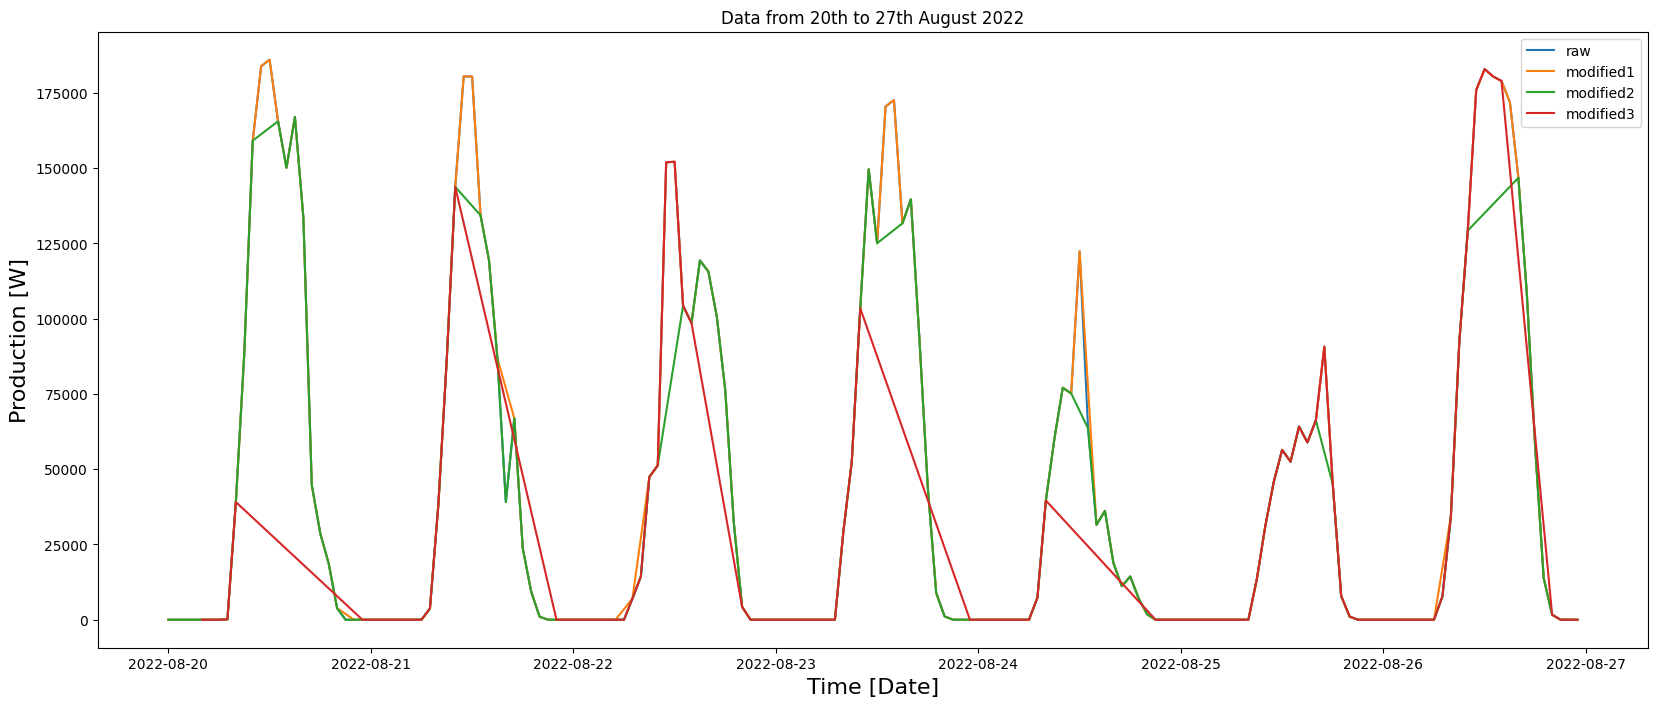

In [40]:

# check raw data over a week
start_date = datetime(2022, 8,20, tzinfo=ZoneInfo("Europe/Tallinn"))
end_date = datetime(2022, 8, 27, tzinfo=ZoneInfo("Europe/Tallinn"))

df_week = df[(df.index >= start_date) & (df.index < end_date)]

plt.figure(figsize=(20,8))
plt.title("Data from 20th to 27th August 2022")
p = sns.lineplot(data=df_week['raw'], label="raw")
p = sns.lineplot(data=df_week['modified1'], label="modified1")
p = sns.lineplot(data=df_week['modified2'], label="modified2")
p = sns.lineplot(data=df_week['modified3'], label="modified3")
p.set_xlabel("Time [Date]", fontsize=16)
p.set_ylabel("Production [W]", fontsize=16)


In [41]:
# weather dataset for comparison -> are the timestamps in UNIX UTC?
df_weather = pd.read_csv('data/Tallinn-Harku-2004-juuni-2024.csv', delimiter=';', decimal=',') # source: https://www.ilmateenistus.ee/wp-content/uploads/2024/07/Tallinn-Harku-2004-juuni-2024.xlsx
df_weather['timestamp'] = pd.to_datetime(df_weather[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + df_weather['time'], utc=True).map(lambda x: x.tz_convert('Europe/Tallinn'))
if pd.Series(df_weather["timestamp"]).is_unique:
    df_weather.set_index('timestamp', inplace=True)

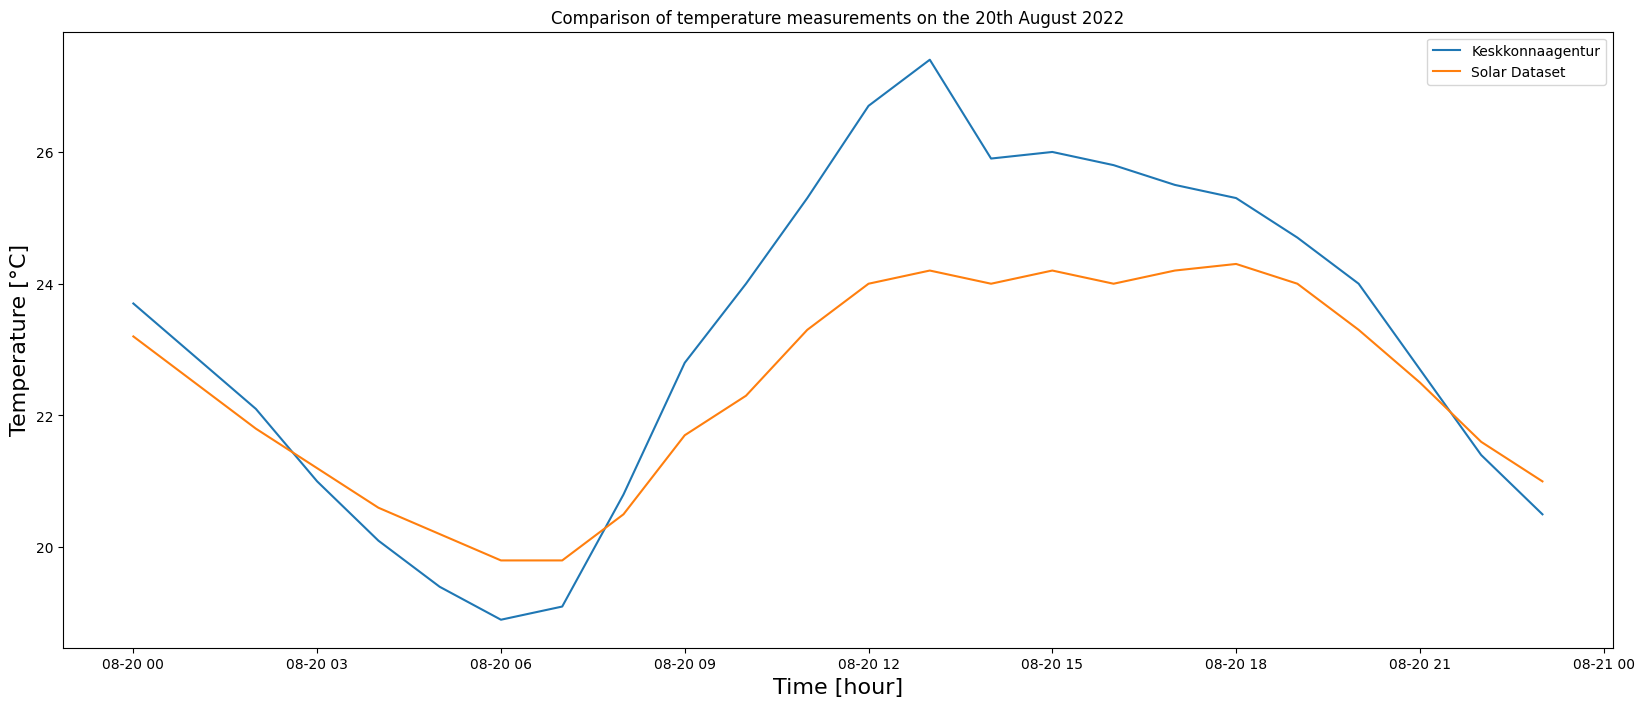

In [42]:
# comparison graph
start_date = datetime(2022, 8,20, tzinfo=ZoneInfo("Europe/Tallinn"))
end_date = datetime(2022, 8, 21, tzinfo=ZoneInfo("Europe/Tallinn"))

temperature_dataset = df['temperature'][(df.index >= start_date) &  (df.index < end_date)]
temperature_keskkonnaagentuur  = df_weather['temp'][(df_weather.index >= start_date) &  (df_weather.index < end_date)]

plt.figure(figsize=(20,8))
plt.title("Comparison of temperature measurements on the 20th August 2022")
p = sns.lineplot(data=temperature_keskkonnaagentuur, label="Keskkonnaagentur")
p = sns.lineplot(data=temperature_dataset, label="Solar Dataset")
p.set_xlabel("Time [hour]", fontsize=16)
p.set_ylabel("Temperature [°C]", fontsize=16)
plt.savefig("diagrams/diagram_comparison_weather_data.pdf")

# Data cleaning
## Missing Data Mechanisms

In [43]:
# missing values
missing_values = df.isnull().sum()
missing_values

raw               0
temperature       0
modified1      1191
modified2      1375
modified3      1137
ts                0
time_delta        1
dtype: int64

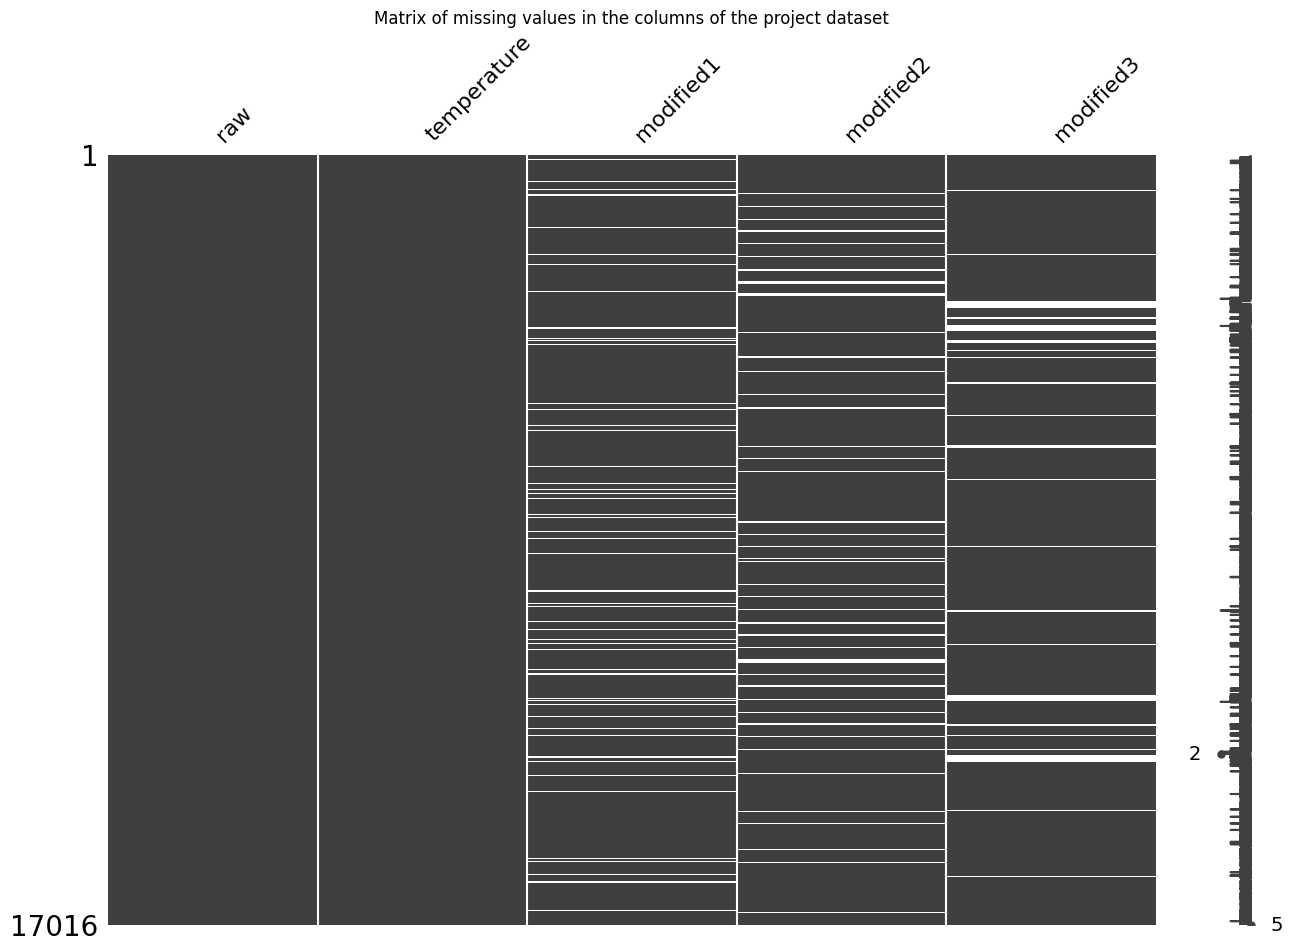

In [44]:
import missingno as msno


msno.matrix(df[["raw", "temperature", "modified1", "modified2", "modified3"]], figsize=(15,10))
plt.title("Matrix of missing values in the columns of the project dataset")
plt.savefig("diagrams/matrix_missing_values.pdf")

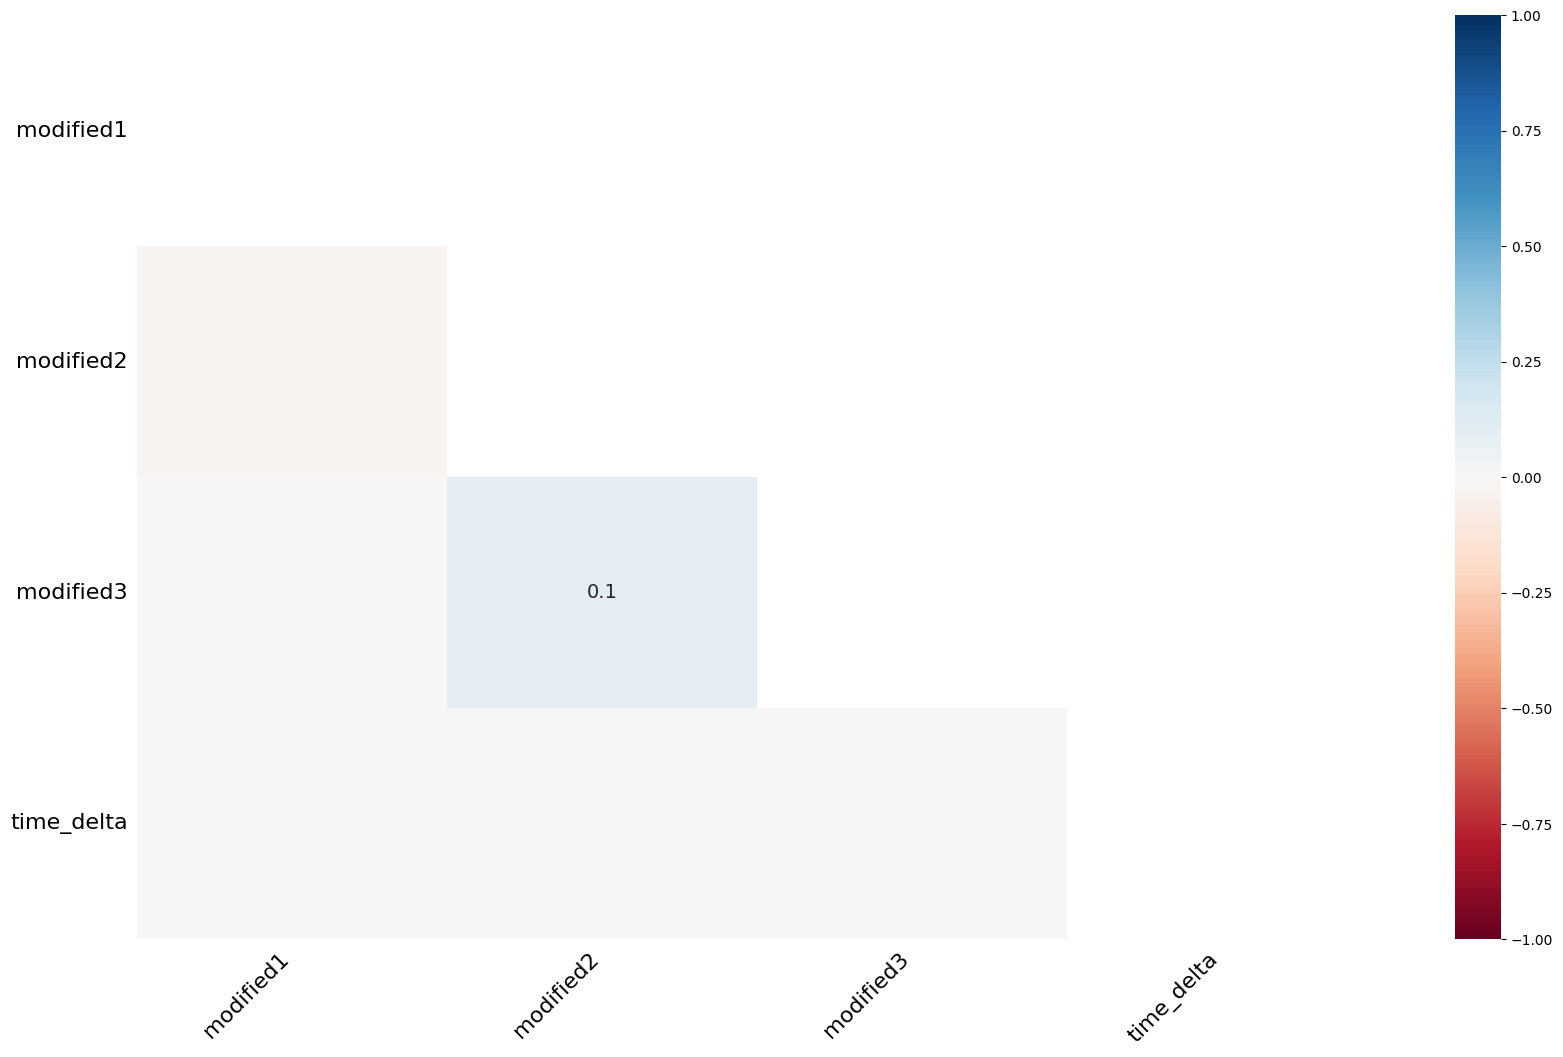

In [45]:
# The missingno correlation heatmap measures nullity correlation:
# how strongly the presence or absence of one variable affects the presence of another.
msno.heatmap(df)
plt.show()

In [46]:
# test if the temperature might influence the missing of data
no_modified_1 = df[df['modified1'].isnull()]
no_modified_2 = df[df['modified2'].isnull()]
no_modified_3 = df[df['modified3'].isnull()]

print("Mean, Std, Min of temperature during missing modified1 values:", no_modified_1['temperature'].mean(), no_modified_1['temperature'].std(), no_modified_1['temperature'].min())
print("Mean, Std, Min of temperature during missing modified2 values:", no_modified_2['temperature'].mean(), no_modified_2['temperature'].std(), no_modified_2['temperature'].min())
print("Mean, Std, Min of temperature during missing modified3 values:", no_modified_3['temperature'].mean(), no_modified_3['temperature'].std(), no_modified_3['temperature'].min())
print("Mean, Std, Min of temperature of whole dataset:",df['temperature'].mean(), df['temperature'].std(), df['temperature'].min())

print("Mean, Std, Min of raw during missing modified1 values:", no_modified_1['raw'].mean(), no_modified_1['raw'].std(), no_modified_1['raw'].min())
print("Mean, Std, Min of raw during missing modified2 values:", no_modified_2['raw'].mean(), no_modified_2['raw'].std(), no_modified_2['raw'].min())
print("Mean, Std, Min of raw during missing modified3 values:",no_modified_3['raw'].mean(), no_modified_3['raw'].std(), no_modified_3['raw'].min())
print("Mean, Std, Min of raw of whole dataset:",df['raw'].mean(), df['raw'].std(), df['raw'].min())

Mean, Std, Min of temperature during missing modified1 values: 6.486314021830394 9.254695238913758 -24.0
Mean, Std, Min of temperature during missing modified2 values: 10.246545454545455 9.879720642752384 -18.9
Mean, Std, Min of temperature during missing modified3 values: 24.03104661389622 2.2599728229953 21.1
Mean, Std, Min of temperature of whole dataset: 6.609191349318289 9.292033255121268 -24.5
Mean, Std, Min of raw during missing modified1 values: 31207.857506297227 59856.04952103751 0.0
Mean, Std, Min of raw during missing modified2 values: 166656.37769454543 87758.9772307748 660.08
Mean, Std, Min of raw during missing modified3 values: 78156.51364116094 77177.63983469969 0.0
Mean, Std, Min of raw of whole dataset: 36912.094887752704 66907.41034729625 0.0


## Missing Data Handling

Metrics to compare missing data handling: standard error, number of missing rows, absolute error

In [74]:
modified_1 = df[['raw','temperature','modified1']]
modified_1_full = modified_1.copy()

missing = modified_1[modified_1.isnull()['modified1'] == True]

missing.describe()

,raw,temperature,modified1
count,1191.000000,1191.000000,0.0
mean,31207.857506,6.486314,NaN
std,59856.049521,9.254695,NaN
min,0.000000,-24.000000,NaN
25%,0.000000,-0.200000,NaN
50%,0.000000,6.500000,NaN
75%,30611.805000,13.400000,NaN
max,301335.730000,29.500000,NaN


In [75]:
# Method 1: Deletion

deletion_df = modified_1.dropna(subset=['modified1'])
deletion_df['absolute_error'] = (deletion_df['raw'] - deletion_df['modified1']).abs()
deletion_df.describe()

/tmp/ipykernel_3213/2612078159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deletion_df['absolute_error'] = (deletion_df['raw'] - deletion_df['modified1']).abs()


,raw,temperature,modified1,absolute_error
count,15825.000000,15825.000000,15825.000000,15825.0
mean,37341.399578,6.618439,37341.399578,0.0
std,67390.437085,9.295063,67390.437085,0.0
min,0.000000,-24.500000,0.000000,0.0
25%,0.000000,-0.200000,0.000000,0.0
50%,0.000000,6.400000,0.000000,0.0
75%,39325.850000,13.400000,39325.850000,0.0
max,301630.010000,30.100000,301630.010000,0.0


In [76]:
# Method 3: Mean

mean_df = pd.DataFrame(modified_1['modified1'].fillna(modified_1['modified1'].mean()))
mean_df.rename(columns = {'modified1':'mean'}, inplace=True)

modified_1 = modified_1.join(mean_df['mean'])
missing = missing.join(mean_df['mean']) 

In [77]:
# Method 2: Linear Interpolation

linear_df = modified_1.interpolate(method ='linear', limit_direction ='forward', axis='columns')
linear_df.rename(columns = {'modified1':'li'}, inplace=True)
linear_df.describe()

modified_1 = modified_1.join(linear_df['li'])
missing = missing.join(linear_df['li'])

In [78]:
# Method 3: MICE

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

#imputer = SimpleImputer(strategy='mean')
#imputer = SimpleImputer(strategy='median')
imputer = KNNImputer(n_neighbors=5)

imputed_values = imputer.fit_transform(modified_1.reset_index()[['modified1','temperature']])
imputed_values = pd.DataFrame(imputed_values[:,0])
imputed_values.set_index(modified_1.index, inplace=True)
imputed_values.rename(columns = {0:'mice'}, inplace=True)

modified_1 = modified_1.join(imputed_values['mice'])
missing = missing.join(imputed_values['mice'])

missing['err-mean'] = (missing['raw'] - missing['mean']).abs()
missing['err-li'] = (missing['raw'] - missing['li']).abs()
missing['err-mice'] = (missing['raw'] - missing['mice']).abs()
missing['err-sq-mean'] = missing['err-mean'].pow(2)
missing['err-sq-li'] = missing['err-li'].pow(2)
missing['err-sq-mice'] = missing['err-mice'].pow(2)
missing.describe()


,raw,temperature,modified1,mean,li,mice,err-mean,err-li,err-mice,err-sq-mean,err-sq-li,err-sq-mice
count,1191.000000,1191.000000,0.0,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1.191000e+03,1.191000e+03,1.191000e+03
mean,31207.857506,6.486314,NaN,37341.399578,18673.942946,36168.286339,46096.502868,37058.257082,44139.661209,3.617359e+09,3.736721e+09,4.215757e+09
std,59856.049521,9.254695,NaN,0.000000,4.627348,34319.929082,38648.744092,48635.301095,47637.722372,8.028275e+09,1.002987e+10,8.972341e+09
min,0.000000,-24.000000,NaN,37341.399578,18658.699789,0.000000,92.770422,185.700211,0.000000,8.606351e+03,3.448457e+04,0.000000e+00
25%,0.000000,-0.200000,NaN,37341.399578,18670.599789,6157.344000,36545.379578,18666.699789,7844.009000,1.335566e+09,3.484457e+08,6.153163e+07
50%,0.000000,6.500000,NaN,37341.399578,18673.949789,29805.378000,37341.399578,18672.549789,31379.542000,1.394380e+09,3.486641e+08,9.846757e+08
75%,30611.805000,13.400000,NaN,37341.399578,18677.399789,53964.134000,37341.399578,18680.824789,61415.322000,1.394380e+09,3.489732e+08,3.771842e+09
max,301335.730000,29.500000,NaN,37341.399578,18685.449789,165854.484000,263994.330422,282663.730211,291547.950000,6.969301e+10,7.989878e+10,8.500021e+10


In [80]:
modified_1.describe()
print("Absolute error of mean (deletion):", abs(modified_1['raw'].mean() - deletion_df['modified1'].mean()))
print("Absolute error of mean (mean imp.):", abs(modified_1['raw'].mean() - modified_1['mean'].mean()))
print("Absolute error of mean (li):", abs(modified_1['raw'].mean() - modified_1['li'].mean()))
print("Absolute error of mean (mice):", abs(modified_1['raw'].mean() - modified_1['mice'].mean()))

print("Absolute error of std (deletion):", abs(modified_1['raw'].std() - deletion_df['modified1'].std()))
print("Absolute error of std (mean imp.):", abs(modified_1['raw'].std() - modified_1['mean'].std()))
print("Absolute error of std (li):", abs(modified_1['raw'].std() - modified_1['li'].std()))
print("Absolute error of std (mice):", abs(modified_1['raw'].std() - modified_1['mice'].std()))

Absolute error of mean (deletion): 429.30469013038964
Absolute error of mean (mean imp.): 429.30469013038964
Absolute error of mean (li): 877.2856277251194
Absolute error of mean (mice): 347.1950364362856
Absolute error of std (deletion): 483.02673807587416
Absolute error of std (mean imp.): 1918.3236841439648
Absolute error of std (li): 1744.0290676743462
Absolute error of std (mice): 1286.9233492120693
